# Effect of weights in the power spectrum estimator and the modelling

## Formalism
In power spectrum analysis, there are two types of weighting that exist in the estimator. 

First of all, there is a **field-level** weighting that directly applies to the tracer field. For example, for galaxy clustering, the galaxy number density is modified by the redshift kernel, i.e. $\rm dn/dz$, of the sample as well as the survey geometry. For HI, this is usually ignored, but effects such as bandpass errors are effectively in this category.

On the other hand, there can be a **grid-level** weighting that is up to the choice of the analyst. For example, in galaxy clustering, it is common to perform the gridding of the galaxy catalogue to the mesh grids and then apply a FKP weighting. In HI, it is common to apply an inverse noise variance weighting based on the number of data time stamps in each grid.

These two weightings are different **because there are several steps of data processing in between the two**. In `meer21cm`, the implementation of the power spectrum modelling follows:

$$
\begin{split}
{\delta}^{\rm obs}_{1,2} (\vec{x}) =  \Bigg[\bigg[\Big[\big[{\delta}^{\rm theory}_{1,2} (\vec{x})  \circledast B_{1,2}(\vec{x})\big] 
 \times {w}^f_{1,2}(\vec{x})\Big]
 \circledast G^{\rm map}_{1,2}(\vec{x})\bigg] 
 \circledast G^{\rm grid}_{1,2}(\vec{x})\Bigg] 
 \times {w}^g_{1,2}(\vec{x})
\end{split}
$$
where ${w}^{f/g}_{1,2}$ denotes the field/grid weights for the first/second tracer, $\circledast$ denotes convolution, $B_{1,2}$ denotes the primary beam attenuation and channelisation, $G_{\rm map}$ denotes the effect of sky map-making and $G_{\rm grid}$ denotes the effect of gridding.

For this note, let us use mock galaxy to study the effects of the two weightings. We use flat sky approximation and only look at galaxy auto-power, so that there is no beam, map-making or gridding ($B = G_{\rm map} = G_{\rm grid} = \delta_{\rm D}$, the Dirac delta).

## Mock generation

Let us generate a catalogue of mock galaxies, with a survey geometry and a non-uniform redshift distribution:

In [1]:
from meer21cm.mock import MockSimulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows
from scipy.interpolate import interp1d
from meer21cm.util import center_to_edges, freq_to_redshift, radec_to_indx
from meer21cm.plot import plot_map
from meer21cm.power import power_weights_renorm

/Users/zhaotingchen/miniconda3/envs/jax/lib/python3.12/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion


In [2]:
# start from scratch, generate galaxy catalogue that is trimmed and have dndz
mock = MockSimulation(
    survey="meerklass_2021",
    band="L",
)
dndz = interp1d(np.linspace(mock.z_ch.min(),mock.z_ch.max(),100),windows.blackmanharris(100),bounds_error=False,fill_value=0)
raminMK, ramaxMK = 334, 357
decminMK, decmaxMK = -35, -26.5
ra_range = (raminMK, ramaxMK)
dec_range = (decminMK, decmaxMK)
# all the other settings follow the default, which corresponds to the MeerKLASS L-band deep-field survey
mock = MockSimulation(
    survey="meerklass_2021",
    band="L",
    flat_sky=True,
    #num_discrete_source=1e5,
    num_discrete_source=1e5,
    seed=12345,
    tracer_bias_2=1.0,
    mean_amp_1='average_hi_temp',
    ra_range=ra_range,
    dec_range=dec_range,
    discrete_source_dndz=dndz,
    #seed=101,
)
# generate the mock tracer
mock.propagate_mock_tracer_to_gal_cat()
# grid to galaxy number count
gal_count,_,_ = mock.grid_gal_to_field()

Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False
Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False
Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False
Note: redshifts have been re-sorted (earliest first)
no input beam found, setting include_beam to False


/Users/zhaotingchen/miniconda3/envs/jax/lib/python3.12/site-packages/numpy/fft/_helper.py:170: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1.0 / (n * d)
/Users/zhaotingchen/miniconda3/envs/jax/lib/python3.12/site-packages/numpy/fft/_helper.py:177: RuntimeWarning: invalid value encountered in multiply
  return results * val
/Users/zhaotingchen/miniconda3/envs/jax/lib/python3.12/site-packages/numpy/fft/_helper.py:170: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1.0 / (n * d)
/Users/zhaotingchen/miniconda3/envs/jax/lib/python3.12/site-packages/numpy/fft/_helper.py:177: RuntimeWarning: invalid value encountered in multiply
  return results * val


Note: redshifts have been re-sorted (earliest first)


In [3]:
mock.k1dbins = np.linspace(
    mock.k_mode[mock.k_mode!=0].min(),
    mock.k_mode[mock.k_mode!=0].max(),
    16
)

let us first take a look at the galaxies we generate. The input asserts two field-level weights, which is the survey area:

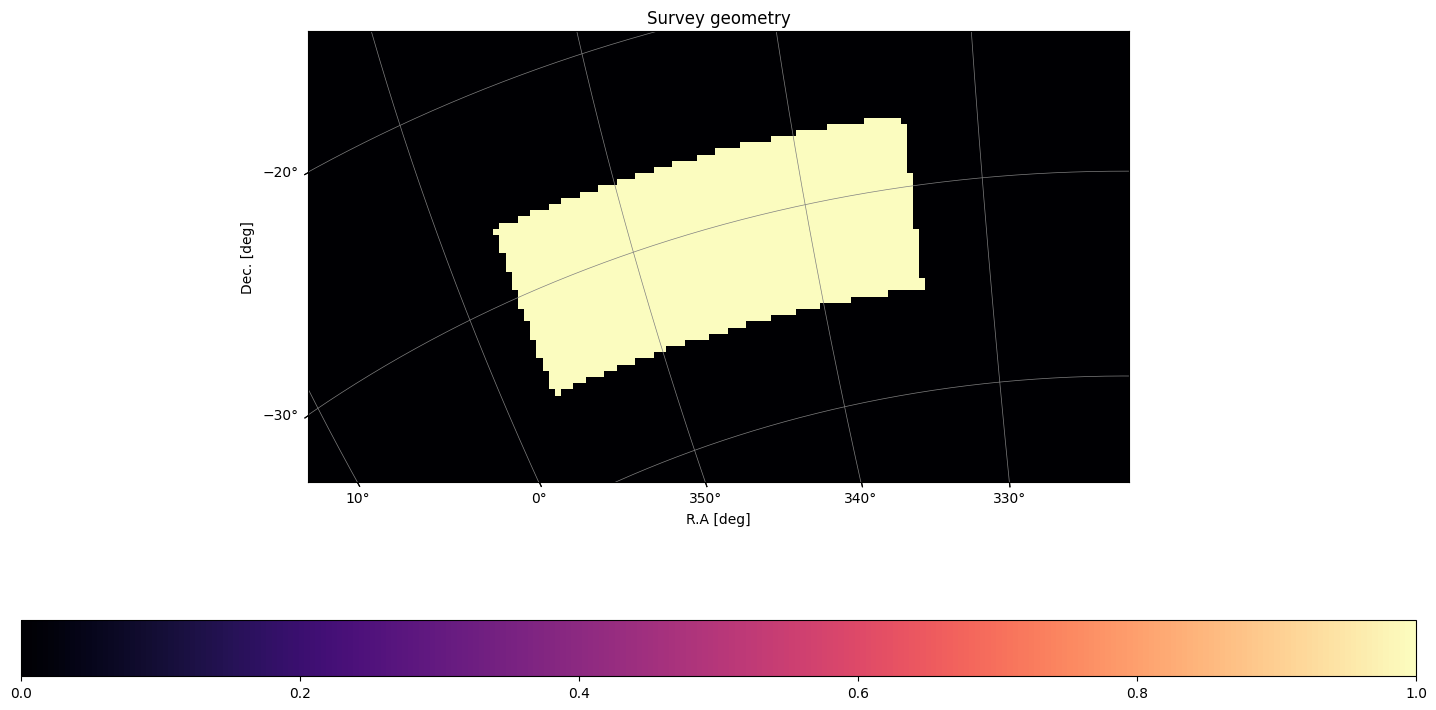

In [4]:
plot_map(mock.W_HI,mock.wproj,title='Survey geometry')

and the redshift kernel:

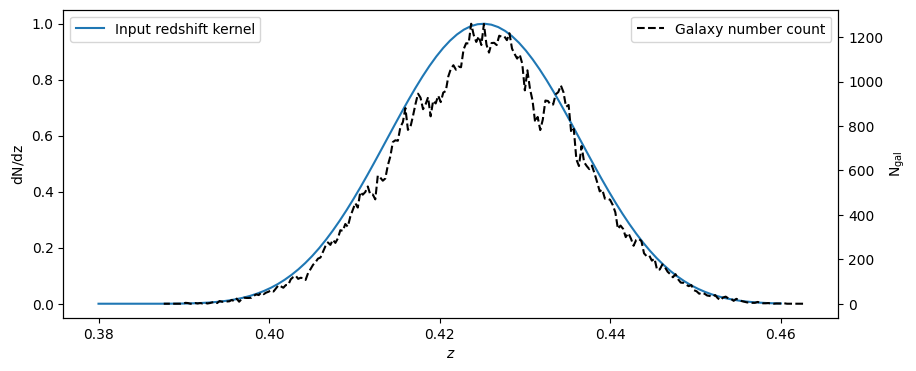

In [5]:
plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(np.linspace(0.38,0.46,100),dndz(np.linspace(0.38,0.46,100)),label='Input redshift kernel')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rm dN/dz$')
ax.legend(loc='upper left')
ax2 = ax.twinx()
ax2.plot(mock.z_ch,gal_count.sum(axis=(0,1)),label='Galaxy number count',
         ls='--',c='k')
ax2.set_ylabel(r'$\rm N_{gal}$')
ax2.legend(loc='upper right')


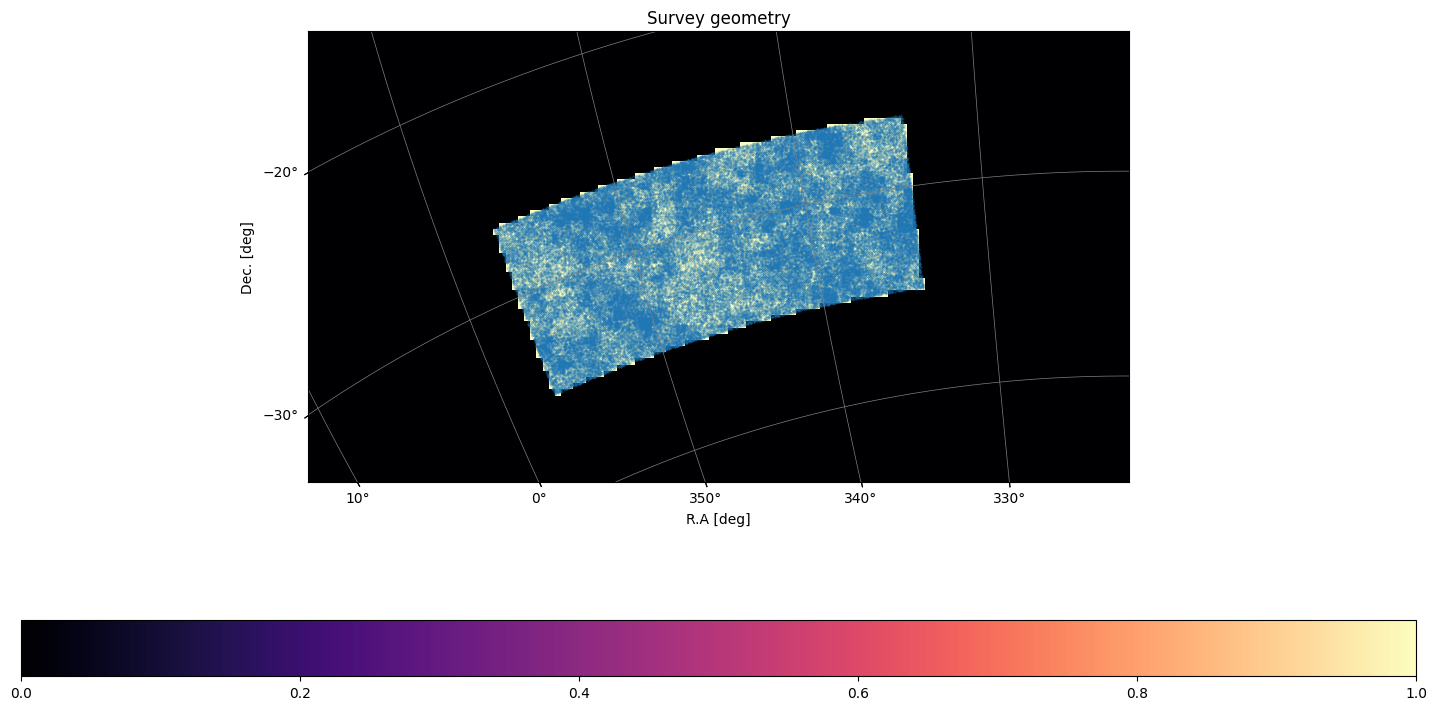

In [6]:
# visualise the galaxy positions:
plot_map(mock.W_HI,mock.wproj,title='Survey geometry')
ax = plt.gca()
ax.scatter(mock.ra_gal,mock.dec_gal,s=0.1,alpha=0.5,
           transform=ax.get_transform('world'),)

## Field-level weights

We can then assemble the field-level weights:

In [7]:
# the dndz projected to the 3D box
dndz_box = mock.discrete_source_dndz(mock._box_voxel_redshift)
# the survey geometry
geomoetry_gal = mock.w_HI.copy()
# the field-level weights
wf_gal = dndz_box * geomoetry_gal
# renormalise, note that this is necessary
wf_gal /= wf_gal.mean()

And then calculate the power spectrum:

In [8]:
# galaxy number count to overdensity
mock.field_2 = gal_count/gal_count.mean() - 1
mock.weights_field_2 = wf_gal.copy()
mock.mean_center_2 = False
mock.unitless_2 = False
# G_grid = 1
mock.compensate = [False,False]
# G_map = 1
mock.include_sky_sampling = [False,False]
# B = 1
mock.include_beam = [False,False]
# no grid weights
mock.weights_grid_2 = None
# turn off renormalisation
mock.renorm_weights_2 = False
weights_renorm = power_weights_renorm(wf_gal)
# get the 3D power spectrum
power_mock = mock.auto_power_3d_2.copy()
# since we set b_g = 1, the input model power is the same as the matter power spectrum
power_model_no_weights = mock.auto_power_matter_model.copy()
# the model power is then convolved with the field-level weights
power_model_weights = mock.auto_power_tracer_2_model.copy()
# shot noise
shot_noise = np.prod(mock.box_len) / gal_count.sum()

Visualise it in 1D:

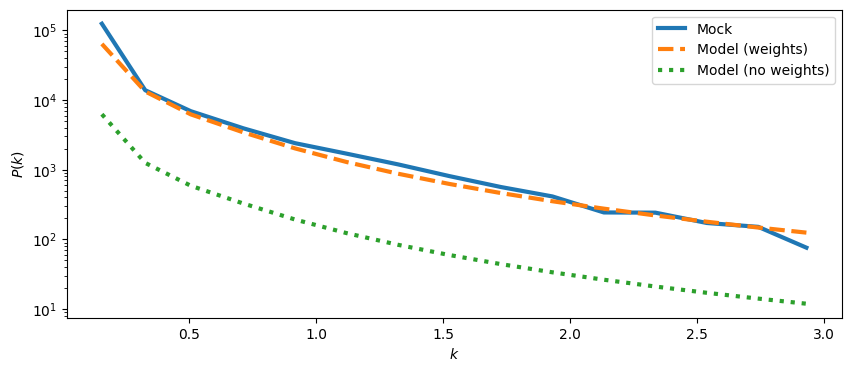

In [9]:
power_1d_mock,keff,nmodes = mock.get_1d_power(power_mock)
power_1d_model_no_weights,_,_ = mock.get_1d_power(power_model_no_weights)
power_1d_model_weights,_,_ = mock.get_1d_power(power_model_weights)
plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(keff,power_1d_mock-shot_noise,label='Mock',ls='-',lw=3)
ax.plot(keff,power_1d_model_weights,label='Model (weights)',ls='--',lw=3)
ax.plot(keff,power_1d_model_no_weights,label='Model (no weights)',ls=':',lw=3)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')
ax.set_yscale('log')
ax.legend()


Or you can visualise the power spectrum in 2D:

/var/folders/g4/7xh65ljx6l17g9wztg7t6c2w0000gn/T/ipykernel_6617/625691630.py:7: RuntimeWarning: invalid value encountered in log10
  mock.kperpbins,mock.kparabins,np.log10(pmock_cy).T,


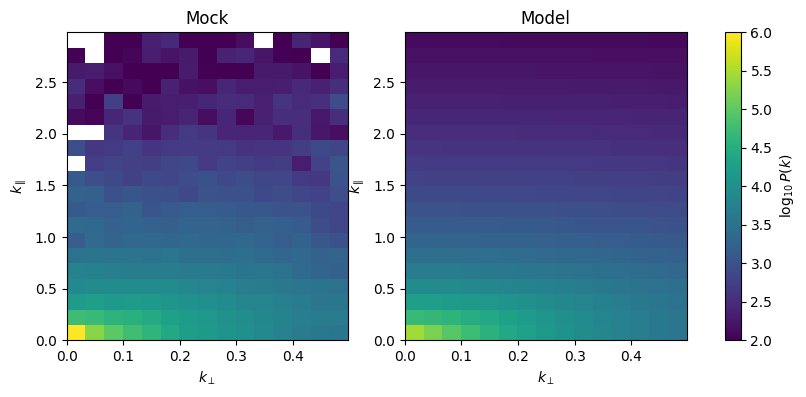

In [10]:
mock.kperpbins = np.linspace(0,mock.k_perp.max(),16)
mock.kparabins = np.linspace(0,mock.k_para.max(),21)
pmock_cy,_ = mock.get_cy_power(power_mock-shot_noise)
pmock_cy_weights,_ = mock.get_cy_power(power_model_weights)
fig,axes = plt.subplots(1,2,figsize=(10,4))
axes[0].pcolormesh(
    mock.kperpbins,mock.kparabins,np.log10(pmock_cy).T,
    vmin=2,vmax=6,
)
im = axes[1].pcolormesh(
    mock.kperpbins,mock.kparabins,np.log10(pmock_cy_weights).T,
    vmin=2,vmax=6,
)
axes[0].set_xlabel(r'$k_\perp$')
axes[0].set_ylabel(r'$k_\parallel$')
axes[0].set_title('Mock')
axes[1].set_xlabel(r'$k_\perp$')
axes[1].set_ylabel(r'$k_\parallel$')
axes[1].set_title('Model')
plt.colorbar(im,ax=axes[:],label=r'$\log_{10} P(k)$')

Note that the measured power spectrum has an artificial increase in amplitude comparing to the input model. This is because the redshift kernel artifically creates "fluctuations". If you want to have a normalised estimator, you can simply apply a renormalisation (which is the same as rescaling the window function matrix so that the sum of each row in the window function matrix is 1):

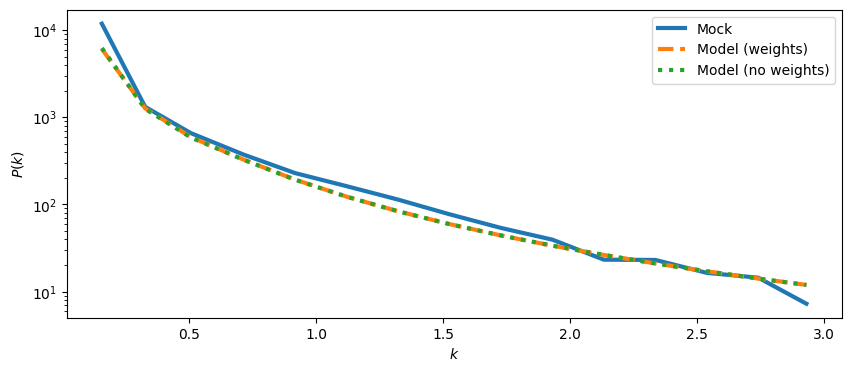

In [11]:
renorm_weights = power_weights_renorm(wf_gal, wf_gal)
plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(keff,(power_1d_mock-shot_noise)*renorm_weights,label='Mock',ls='-',lw=3)
ax.plot(keff,power_1d_model_weights*renorm_weights,label='Model (weights)',ls='--',lw=3)
ax.plot(keff,power_1d_model_no_weights,label='Model (no weights)',ls=':',lw=3)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')
ax.set_yscale('log')
ax.legend()

Note that the model with and without weights are not identical, since there is still a convolution that induces mode mixing. (although the difference is very small due to 1D averaging)

In [12]:
power_1d_model_weights/power_1d_model_no_weights*renorm_weights

array([0.97574688, 1.01204041, 1.01053451, 1.00354803, 1.00198898,
       1.00123418, 1.00092003, 1.00065156, 1.00053524, 1.00046837,
       1.00030277, 1.00029214, 1.00024735, 1.00023338, 1.00100242])

In practice, you can simply turn on `renorm_weights_field_1` to automatically apply the renormalisation, however you still need to calculate the shot noise yourself:

In [13]:
mock.renorm_weights_2 = True
power_1d_mock,keff,nmodes = mock.get_1d_power(mock.auto_power_3d_2)
power_1d_model_weights,_,_ = mock.get_1d_power(mock.auto_power_tracer_2_model)
shot_noise = np.prod(mock.box_len) / gal_count.sum() * renorm_weights

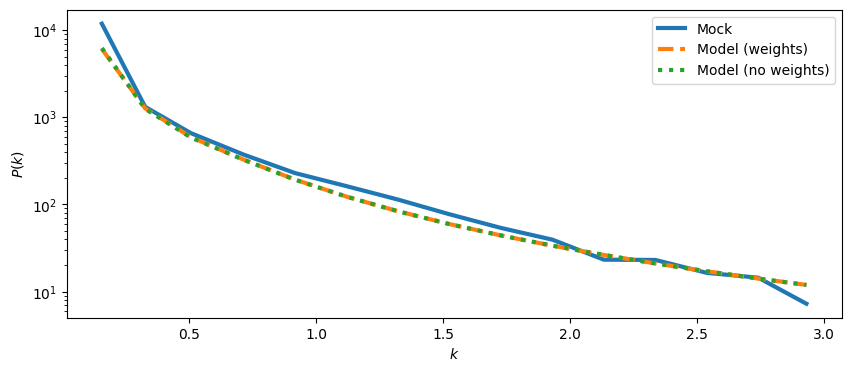

In [14]:

plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(keff,(power_1d_mock-shot_noise),label='Mock',ls='-',lw=3)
ax.plot(keff,power_1d_model_weights,label='Model (weights)',ls='--',lw=3)
ax.plot(keff,power_1d_model_no_weights,label='Model (no weights)',ls=':',lw=3)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')
ax.set_yscale('log')
ax.legend()

## Grid level weights
Now suppose that you want to also apply some weights yourself on the galaxy number count. This weighting can be a taper in the angular space, inverse noise variance weighting in the case of HI, etc.

Note that, it is usually assumed that the HI only has grid level weights and galaxy only has field level weights. **If both weights are non-uniform**, the renormalisation becomes highly-nontrivial unless $B = G_{\rm map} = G_{\rm grid} = \delta_{\rm D}$, which is the case we are looking at here.

Now let us apply a taper:

In [15]:
taper = (
    windows.blackmanharris(mock.box_ndim[0])[:,None,None] # taper in x-direction
    * windows.blackmanharris(mock.box_ndim[1])[None,:,None] # taper in y-direction
    * np.ones(mock.box_ndim[2])[None,None,:] # does not taper in z-direction
)
#taper/=taper.mean()
# specify the grid-level weights
mock.field_2 = (gal_count/gal_count.mean() - 1)
mock.weights_grid_2 = (taper.copy())
# we turn off the auto renormalisation first
mock.renorm_weights_2 = False

In [16]:
power_1d_mock,keff,nmodes = mock.get_1d_power(mock.auto_power_3d_2)
# shot noise is still the same, since convolution only affects scale-dependent part
shot_noise = np.prod(mock.box_len) / gal_count.sum() * renorm_weights

Note that, when $B = G_{\rm map} = G_{\rm grid} = \delta_{\rm D}$, the observed density reduces to 

$$
{\delta}^{\rm obs}_{1,2} (\vec{x}) =  {\delta}^{\rm theory}_{1,2} 
 \times {w}^f_{1,2}(\vec{x})  \times {w}^g_{1,2}(\vec{x})
$$

so the correct renormalisation in this case is:

In [17]:

renorm = power_weights_renorm(taper*wf_gal,taper*wf_gal)
renorm


np.float64(0.30975652854046903)

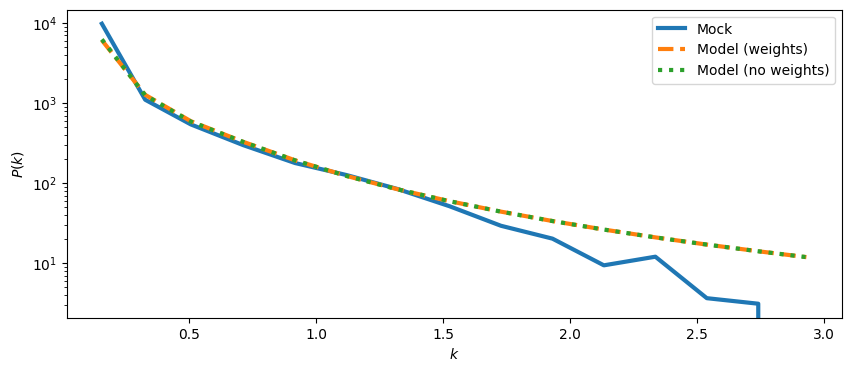

In [19]:
plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(keff,power_1d_mock * renorm - shot_noise,label='Mock',ls='-',lw=3)
ax.plot(keff,power_1d_model_weights,label='Model (weights)',ls='--',lw=3)
ax.plot(keff,power_1d_model_no_weights,label='Model (no weights)',ls=':',lw=3)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')

ax.set_yscale('log')
ax.legend()

In other words, we can define three rescaling factors, $F(w_f)$, $F(w_g)$, $F(w_g \, w_f)$. For the observed tracer field, the correct renormalisation is given by $F(w_g \, w_f)$. For the shot noise, the correct renormalisation is given by $F(w_f)$.

## Cross-power with different level of weights

Now let us generate some mock HI field. The common assumption is HI only has field level weights (for example frequency taper)

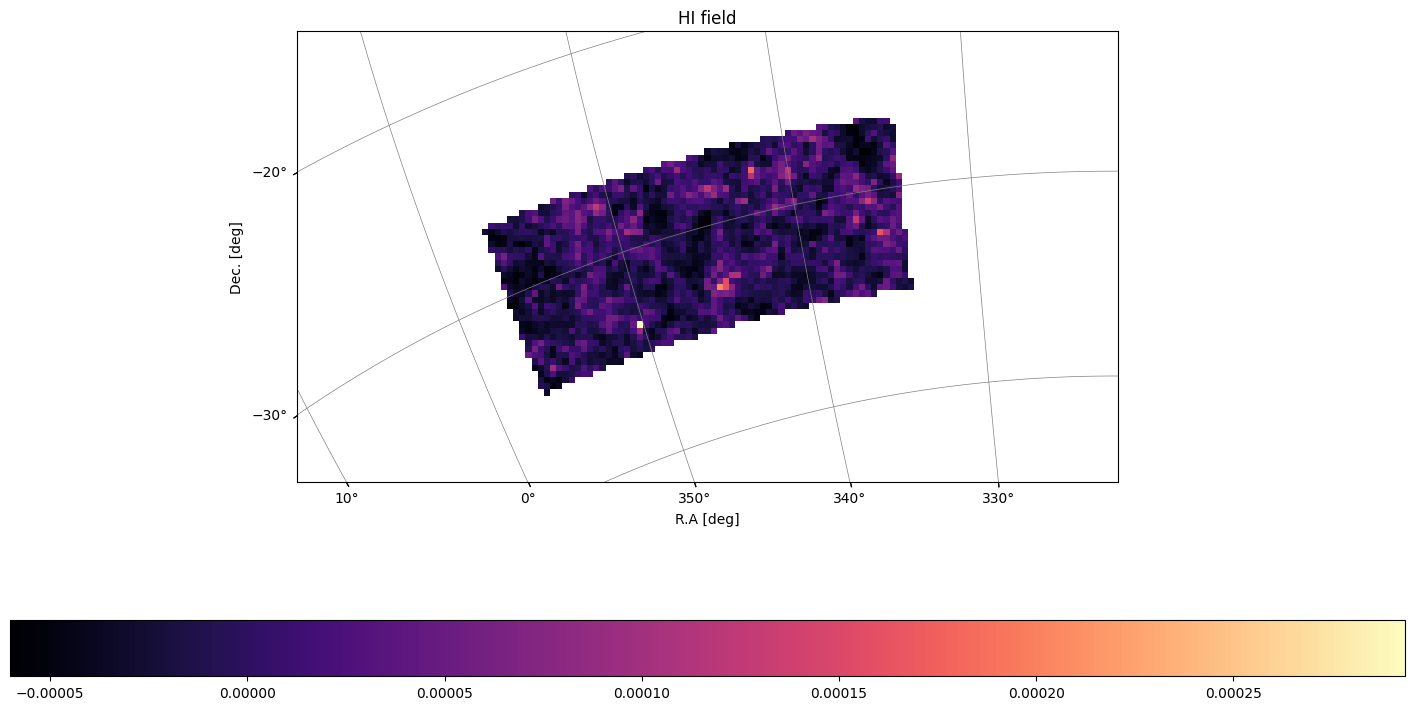

In [20]:
mock.data = mock.propagate_mock_field_to_data(mock.mock_tracer_field_1)
mock.trim_map_to_range()
plot_map(mock.data,mock.wproj,W=mock.W_HI,title='HI field')

In [21]:
mock.field_1 = mock.data
mock.weights_grid_1 = mock.w_HI * windows.blackmanharris(mock.box_ndim[-1])[None,None,:]
mock.weights_field_1 = None
# turn on renormalisation
mock.renorm_weights_1 = True

power_1d_hi_mock,keff,nmodes = mock.get_1d_power(mock.auto_power_3d_1)
power_1d_hi_model,_,_ = mock.get_1d_power(mock.auto_power_tracer_1_model)


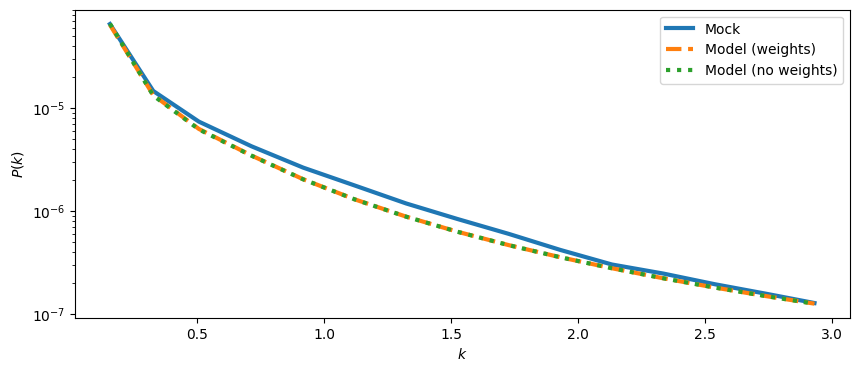

In [22]:
plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(keff,power_1d_hi_mock,label='Mock',ls='-',lw=3)
ax.plot(keff,power_1d_hi_model,label='Model (weights)',ls='--',lw=3)
ax.plot(keff,power_1d_model_no_weights*mock.average_hi_temp**2,label='Model (no weights)',ls=':',lw=3)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')

ax.set_yscale('log')
ax.legend()

In [23]:
# now checking cross-power
mock.mean_center_1 = False
mock.unitless_1 = False
mock.mean_center_2 = False
mock.unitless_2 = False

# field 1 is just HI field, only grid field
mock.field_1 = mock.data
mock.weights_grid_1 = mock.w_HI * windows.blackmanharris(mock.box_ndim[-1])[None,None,:]
mock.weights_field_1 = None
# we turn off the auto renormalisation first
mock.renorm_weights_1 = False

# field 2 is the galaxy field, only field level weights
mock.field_2 = gal_count/gal_count.mean() - 1
mock.weights_field_2 = wf_gal.copy()
mock.weights_grid_2 = mock.w_HI.astype(float)
mock.renorm_weights_2 = False

mock.renorm_weights_cross = False

power_1d_x_mock,keff,nmodes = mock.get_1d_power(mock.cross_power_3d)
power_1d_x_model,_,_ = mock.get_1d_power(mock.cross_power_tracer_model)


In [24]:
renorm_x = power_weights_renorm(mock.weights_grid_1,weights2=mock.weights_field_2*mock.weights_grid_2)
renorm_1 = power_weights_renorm(mock.weights_grid_1, mock.weights_grid_1)

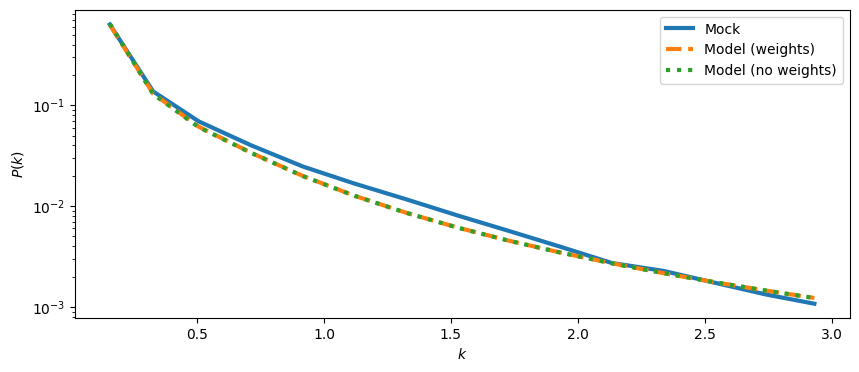

In [26]:
plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(keff,power_1d_x_mock*renorm_x,label='Mock',ls='-',lw=3)
ax.plot(keff,power_1d_x_model*renorm_x,label='Model (weights)',ls='--',lw=3)
ax.plot(keff,power_1d_model_no_weights*mock.average_hi_temp,label='Model (no weights)',ls=':',lw=3)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')

ax.set_yscale('log')
ax.legend()

Again you can also turn on weight renormalisation to automatically account for this:

In [27]:
mock.renorm_weights_cross = True

power_1d_x_mock,keff,nmodes = mock.get_1d_power(mock.cross_power_3d)
power_1d_x_model,_,_ = mock.get_1d_power(mock.cross_power_tracer_model)

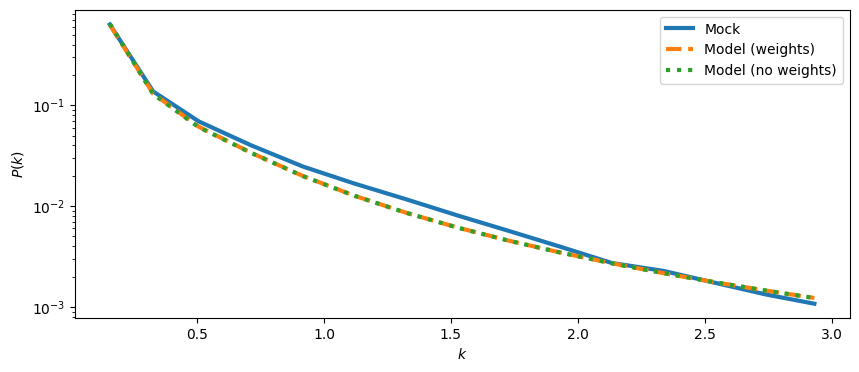

In [28]:
plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(keff,power_1d_x_mock,label='Mock',ls='-',lw=3)
ax.plot(keff,power_1d_x_model,label='Model (weights)',ls='--',lw=3)
ax.plot(keff,power_1d_model_no_weights*mock.average_hi_temp,label='Model (no weights)',ls=':',lw=3)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')

ax.set_yscale('log')
ax.legend()

In practice, all renormalisations are turned on by default. Switch it off only when you know what you are doing. One useful aspect of turning off the renormalisation is to check the shot-noise contribution in its original amplitude, to match with the 1/N expectation (if the gridding scheme is 'nnb'). 